# Combining Raw Data
Chapter 4 of the book: "Build Your Own AI Investor"

In [148]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2021
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

In [149]:
from platform import python_version
print(python_version())

3.7.10


In [150]:
# Set the plotting DPI settings to be a bit higher.
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

In [151]:
def getXDataMerged(myLocalPath='C:/Users/G50/Stock_Data/SimFin2021/'):
    '''
    For combining fundamentals financial data from SimFin,
    or SimFin+ (https://simfin.com/) without API.
    Download Income Statement, Balance Sheet and Cash Flow files,
    Place in a directory and give the directory path to the function.
    Assumes standard filenames from SimFin.
    Returns a DataFrame of the combined result. 
    Prints file infos.
    '''
    incomeStatementData=pd.read_csv(myLocalPath+'us-income-annual.csv',
                                    delimiter=';')
    balanceSheetData=pd.read_csv(myLocalPath+'us-balance-annual.csv',
                                 delimiter=';')
    CashflowData=pd.read_csv(myLocalPath+'us-cashflow-annual.csv',
                             delimiter=';')
    
    print('Income Statement CSV data is(rows, columns): ',
          incomeStatementData.shape)
    print('Balance Sheet CSV data is: ',
          balanceSheetData.shape)
    print('Cash Flow CSV data is: ' ,
          CashflowData.shape)
    

    # Merge the data together
    result = pd.merge(incomeStatementData, balanceSheetData,\
                on=['Ticker','SimFinId','Currency',
                    'Fiscal Year','Report Date','Publish Date'])
    
    result = pd.merge(result, CashflowData,\
                on=['Ticker','SimFinId','Currency',
                    'Fiscal Year','Report Date','Publish Date'])
    
    # dates in correct format
    result["Report Date"] = pd.to_datetime(result["Report Date"]) 
    result["Publish Date"] = pd.to_datetime(result["Publish Date"])
    
    print('Merged X data matrix shape is: ', result.shape)
    
    return result

In [152]:
def getYRawData(my_local_path='C:/Users/G50/Stock_Data/SimFin2021/'):
    '''
    Read stock price data from SimFin or SimFin+ (https://simfin.com/),
    without API.
    Place in a directory and give the directory path to the function.
    Assumes standard filenames from SimFin.
    Returns a DataFrame.
    Prints file info.
    '''
    dailySharePrices=pd.read_csv(my_local_path+
                                 'us-shareprices-daily.csv',
                                 delimiter=';')
    
    dailySharePrices["Date"]=pd.to_datetime(dailySharePrices["Date"])
    print('Stock Price data matrix is: ',dailySharePrices.shape)
    return dailySharePrices

In [130]:
def getYPriceDataNearDate(ticker, date, modifier, dailySharePrices):
    '''
    Return just the y price and volume.
    Take the first day price/volume of the list of days,
    that fall in the window of accepted days.
    'modifier' just modifies the date to look between.
    Returns a list.
    '''
    windowDays=5
    rows = dailySharePrices[
        (dailySharePrices["Date"].between(pd.to_datetime(date)
                                          + pd.Timedelta(days=modifier),
                                          pd.to_datetime(date)
                                          + pd.Timedelta(days=windowDays
                                                         +modifier)
                                         )
        ) & (dailySharePrices["Ticker"]==ticker)]
    
    if rows.empty:
        return [ticker, np.float("NaN"),\
                np.datetime64('NaT'),\
                np.float("NaN")]
    else:
        return [ticker, rows.iloc[0]["Open"],\
                rows.iloc[0]["Date"],\
                rows.iloc[0]["Volume"]*rows.iloc[0]["Open"]]

In [131]:
d=getYRawData()

Stock Price data matrix is:  (6546736, 11)


In [132]:
getYPriceDataNearDate('AAPL', '2012-05-12', 0, d)

['AAPL', 20.09, Timestamp('2012-05-14 00:00:00'), 253009442.0]

In [133]:
getYPriceDataNearDate('AAPL', '2012-05-12', 30, d)

['AAPL', 20.99, Timestamp('2012-06-11 00:00:00'), 443237433.99999994]

In [134]:
def getYPricesReportDateAndTargetDate(x, d, modifier=365):
    '''
    Takes in all fundamental data X, all stock prices over time y,
    and modifier (days), and returns the stock price info for the
    data report date, as well as the stock price one year from that date
    (if modifier is left as modifier=365)
    '''
    # Preallocation list of list of 2 
    # [(price at date) (price at date + modifier)]
    y = [[None]*8 for i in range(len(x))] 
    
    whichDateCol='Publish Date'# or 'Report Date', 
    # is the performance date from->to. Want this to be publish date.
    
    # Because of time lag between report date
    # (which can't be actioned on) and publish date
    # (data we can trade with)
    
    # In the end decided this instead of iterating through index.
    # Iterate through a range rather than index, as X might not have
    # monotonic increasing index 1, 2, 3, etc.
    i=0
    for index in range(len(x)):
        y[i]=(getYPriceDataNearDate(x['Ticker'].iloc[index], 
                                    x[whichDateCol].iloc[index],0,d)
              +getYPriceDataNearDate(x['Ticker'].iloc[index], 
                                     x[whichDateCol].iloc[index], 
                                     modifier, d))
        i=i+1
        
    return y

In [ ]:
'''def getYPricesReportDateAndTargetDate(x, d, modifier=365):
    '''
    #Takes in all fundamental data X, all stock prices over time y,
    #and modifier (days), and returns the stock price info for the
    #data report date, as well as the stock price one year from that date
    #(if modifier is left as modifier=365)
    '''
    # Preallocation list of list of 2 
    # [(price at date) (price at date + modifier)]
    y = [[None]*8 for i in range(len(x))] 
    
    whichDateCol='Publish Date'# or 'Report Date', 
    # is the performance date from->to. Want this to be publish date.
    
    # Because of time lag between report date
    # (which can't be actioned on) and publish date
    # (data we can trade with)

    for i in x.index:
        y[i]=(getYPriceDataNearDate(x['Ticker'].loc[i], 
                                    x[whichDateCol].loc[i],0,d)
              +getYPriceDataNearDate(x['Ticker'].loc[i], 
                                     x[whichDateCol].loc[i], 
                                     modifier, d))
        
    return y'''

In [48]:
X = getXDataMerged()
X.to_csv("Annual_Stock_Price_Fundamentals.csv")

Income Statement CSV data is(rows, columns):  (19866, 28)
Balance Sheet CSV data is:  (19866, 30)
Cash Flow CSV data is:  (19866, 28)
Merged X data matrix shape is:  (19866, 74)


In [49]:
X.keys()

Index(['Ticker', 'SimFinId', 'Currency', 'Fiscal Year', 'Fiscal Period_x',
       'Report Date', 'Publish Date', 'Restated Date_x', 'Shares (Basic)_x',
       'Shares (Diluted)_x', 'Revenue', 'Cost of Revenue', 'Gross Profit',
       'Operating Expenses', 'Selling, General & Administrative',
       'Research & Development', 'Depreciation & Amortization_x',
       'Operating Income (Loss)', 'Non-Operating Income (Loss)',
       'Interest Expense, Net', 'Pretax Income (Loss), Adj.',
       'Abnormal Gains (Losses)', 'Pretax Income (Loss)',
       'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses)', 'Net Income', 'Net Income (Common)',
       'Fiscal Period_y', 'Restated Date_y', 'Shares (Basic)_y',
       'Shares (Diluted)_y', 'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
       'Property, Plant & Equipment, Net',
       'Long Ter

In [50]:
d = getYRawData()
d[d['Ticker']=='GOOG']

Stock Price data matrix is:  (6482905, 11)


,Ticker,SimFinId,Date,Open,Low,High,Close,Adj. Close,Dividend,Volume,Shares Outstanding
0,GOOG,18,2014-03-27,568.00,552.92,568.00,558.46,558.46,NaN,13100,336050831.0
1,GOOG,18,2014-03-28,561.20,558.67,566.43,559.99,559.99,NaN,41100,336050831.0
2,GOOG,18,2014-03-31,566.89,556.93,567.00,556.97,556.97,NaN,10800,674462000.0
3,GOOG,18,2014-04-01,558.71,558.71,568.45,567.16,567.16,NaN,7900,674462000.0
4,GOOG,18,2014-04-02,565.11,562.19,604.83,567.00,567.00,NaN,146700,674462000.0
...,...,...,...,...,...,...,...,...,...,...,...
1730,GOOG,18,2021-02-09,2078.54,2078.54,2105.13,2083.51,2083.51,NaN,886247,674136665.0
1731,GOOG,18,2021-02-10,2094.21,2063.09,2108.37,2095.38,2095.38,NaN,1132741,674136665.0
1732,GOOG,18,2021-02-11,2099.51,2077.32,2102.03,2095.89,2095.89,NaN,945650,674136665.0
1733,GOOG,18,2021-02-12,2090.25,2083.13,2108.82,2104.11,2104.11,NaN,855865,674136665.0


### \**Warning** takes a long time

In [51]:
# We want to know the performance for each stock, each year, between 10-K report dates.
# takes VERY long time, several hours,
y = getYPricesReportDateAndTargetDate(x, d, 365) # because of lookups in this function.

In [52]:
y = pd.DataFrame(y, columns=['Ticker', 'Open Price', 'Date', 'Volume',\
                             'Ticker2', 'Open Price2', 'Date2', 'Volume2'
                            ])
y.to_csv("Annual_Stock_Price_Performance.csv")

In [55]:
y

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,16.78,2008-12-19,2.483239e+08,A,29.60,2009-12-21,9.319856e+07
1,A,29.60,2009-12-21,9.319856e+07,A,40.65,2010-12-21,1.469619e+08
2,A,40.10,2010-12-20,1.613504e+08,A,33.99,2011-12-20,1.247977e+08
3,A,33.73,2011-12-16,1.053320e+08,A,39.98,2012-12-17,1.381149e+08
4,A,40.58,2012-12-20,1.545570e+08,A,57.47,2013-12-20,1.697664e+08
...,...,...,...,...,...,...,...,...
19861,ZYXI,0.34,2016-03-31,3.400000e+01,ZYXI,0.31,2017-03-31,2.170000e+02
19862,ZYXI,0.34,2017-04-18,3.502000e+03,ZYXI,3.46,2018-04-18,1.887119e+05
19863,ZYXI,5.00,2018-02-28,5.846550e+05,ZYXI,4.96,2019-02-28,2.961021e+05
19864,ZYXI,5.60,2019-02-26,2.684080e+05,ZYXI,13.09,2020-02-26,3.442356e+06


# Long part done, now remove rows with issues

In [6]:
X=pd.read_csv("Annual_Stock_Price_Fundamentals.csv", index_col=0)
y=pd.read_csv("Annual_Stock_Price_Performance.csv", index_col=0)

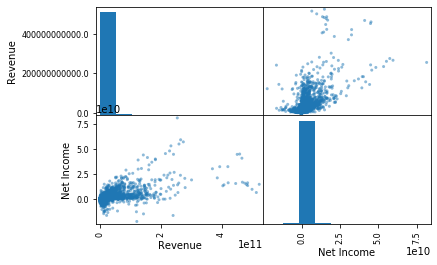

In [10]:
from pandas.plotting import scatter_matrix
attributes=["Revenue","Net Income"]
scatter_matrix(X[attributes]);

In [11]:
# Find out things about Y data
print("y Shape:", y.shape)
print("X Shape:", X.shape)

y Shape: (19866, 8)
X Shape: (19866, 74)


In [12]:
y[(y['Volume']<1e4) | (y['Volume2']<1e4)]# rows with volume issues

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
149,ABCD,1.20,2013-03-08,4290.00,ABCD,2.10,2014-03-10,150225.60
187,ABMC,0.10,2011-03-25,2700.00,ABMC,0.17,2012-03-26,8313.00
188,ABMC,0.13,2012-04-16,139.75,ABMC,0.16,2013-04-16,960.00
189,ABMC,0.20,2013-03-28,350.00,ABMC,0.12,2014-03-28,745.80
190,ABMC,0.11,2014-03-31,115.50,ABMC,0.12,2015-03-31,0.00
...,...,...,...,...,...,...,...,...
19858,ZYXI,0.56,2013-03-28,30968.00,ZYXI,0.43,2014-03-28,43.00
19859,ZYXI,0.43,2014-03-28,43.00,ZYXI,0.14,2015-03-30,518.00
19860,ZYXI,0.14,2015-03-31,182.00,ZYXI,0.34,2016-03-30,0.00
19861,ZYXI,0.34,2016-03-31,34.00,ZYXI,0.31,2017-03-31,217.00


In [13]:
# Now need to filter out rows because not all of the rows have stock performance.

In [14]:
## PROBLEMS
# no accounting for mergers or bankrupcies (use adjusted share closing price)

In [15]:
y.shape

(19866, 8)

In [16]:
# Issue where no share price
bool_list1 = ~y["Open Price"].isnull()
# Issue where there is low/no volume
bool_list2 = ~((y['Volume']<1e4) | (y['Volume2']<1e4))
# Issue where dates missing (Removes latest data too, which we can't use)
bool_list3 = ~y["Date2"].isnull()

y=y[bool_list1 & bool_list2 & bool_list3]
X=X[bool_list1 & bool_list2 & bool_list3]


# Issues where no listed number of shares
bool_list4 = ~X["Shares (Diluted)_x"].isnull()
y=y[bool_list4]
X=X[bool_list4]
               
y=y.reset_index(drop=True)
X=X.reset_index(drop=True)

In [17]:
y

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,16.78,2008-12-19,248323864.0,A,29.60,2009-12-21,9.319856e+07
1,A,29.60,2009-12-21,93198560.0,A,40.65,2010-12-21,1.469619e+08
2,A,40.10,2010-12-20,161350370.0,A,33.99,2011-12-20,1.247977e+08
3,A,33.73,2011-12-16,105332044.0,A,39.98,2012-12-17,1.381149e+08
4,A,40.58,2012-12-20,154557046.0,A,57.47,2013-12-20,1.697664e+08
...,...,...,...,...,...,...,...,...
15583,ZYNE,20.00,2017-03-27,14002920.0,ZYNE,8.69,2018-03-27,1.305273e+06
15584,ZYNE,9.20,2018-03-12,9964106.0,ZYNE,4.85,2019-03-12,3.579475e+06
15585,ZYNE,4.80,2019-03-11,2979552.0,ZYNE,3.61,2020-03-10,2.898415e+06
15586,ZYXI,5.00,2018-02-28,584655.0,ZYXI,4.96,2019-02-28,2.961021e+05


In [18]:
X["Market Cap"] = y["Open Price"]*X["Shares (Diluted)_x"]

In [19]:
X.shape

(15588, 75)

In [20]:
y.shape

(15588, 8)

In [21]:
X.to_csv("Annual_Stock_Price_Fundamentals_Filtered.csv")
y.to_csv("Annual_Stock_Price_Performance_Filtered.csv")

In [22]:
y

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,16.78,2008-12-19,248323864.0,A,29.60,2009-12-21,9.319856e+07
1,A,29.60,2009-12-21,93198560.0,A,40.65,2010-12-21,1.469619e+08
2,A,40.10,2010-12-20,161350370.0,A,33.99,2011-12-20,1.247977e+08
3,A,33.73,2011-12-16,105332044.0,A,39.98,2012-12-17,1.381149e+08
4,A,40.58,2012-12-20,154557046.0,A,57.47,2013-12-20,1.697664e+08
...,...,...,...,...,...,...,...,...
15583,ZYNE,20.00,2017-03-27,14002920.0,ZYNE,8.69,2018-03-27,1.305273e+06
15584,ZYNE,9.20,2018-03-12,9964106.0,ZYNE,4.85,2019-03-12,3.579475e+06
15585,ZYNE,4.80,2019-03-11,2979552.0,ZYNE,3.61,2020-03-10,2.898415e+06
15586,ZYXI,5.00,2018-02-28,584655.0,ZYXI,4.96,2019-02-28,2.961021e+05


In [23]:
X[80:90]

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period_x,Report Date,Publish Date,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Change in Fixed Assets & Intangibles,Net Change in Long Term Investment,Net Cash from Acquisitions & Divestitures,Net Cash from Investing Activities,Dividends Paid,Cash from (Repayment of) Debt,Cash from (Repurchase of) Equity,Net Cash from Financing Activities,Net Change in Cash,Market Cap
80,AAXN,493957,USD,2010,FY,2010-12-31,2011-03-14,2013-03-08,62524446.0,62524446.0,...,-4471702.0,NaN,NaN,-4471702.0,NaN,NaN,877246.0,929393.0,-2820808,2.563502e+08
81,AAXN,493957,USD,2011,FY,2011-12-31,2012-11-15,2014-03-10,59436000.0,59436000.0,...,-2118000.0,-5479000.0,NaN,-7597000.0,NaN,NaN,-31072000.0,-31062000.0,-21383000,4.671670e+08
82,AAXN,493957,USD,2012,FY,2012-12-31,2013-03-08,2015-03-12,53827000.0,54723000.0,...,-1717000.0,3398000.0,NaN,1681000.0,NaN,-9000.0,-18067000.0,-13363000.0,14826000,4.405202e+08
83,AAXN,493957,USD,2013,FY,2013-12-31,2014-03-10,2016-03-07,51880000.0,54152000.0,...,-2072000.0,-19732000.0,-1258000.0,-23062000.0,NaN,-34000.0,-9643000.0,-3189000.0,6144000,1.024014e+09
84,AAXN,493957,USD,2014,FY,2014-12-31,2015-03-12,2017-03-06,52948000.0,54500000.0,...,-2678000.0,-21903000.0,0.0,-24581000.0,NaN,-36000.0,-11442000.0,-4840000.0,6096000,1.224615e+09
85,AAXN,493957,USD,2015,FY,2015-12-31,2016-03-07,2017-03-06,53548000.0,54638000.0,...,-6464000.0,-18359000.0,-11186000.0,-36009000.0,NaN,-80000.0,-4883000.0,603000.0,11159000,1.059977e+09
86,AAXN,493957,USD,2016,FY,2016-12-31,2017-03-06,2017-03-06,52667000.0,53536000.0,...,-8410000.0,8865000.0,-3500000.0,-3045000.0,NaN,-107000.0,-33268000.0,-34661000.0,-18875000,1.220621e+09
87,AAXN,493957,USD,2017,FY,2017-12-31,2018-03-01,2018-03-01,52726000.0,53898000.0,...,-11419000.0,41130000.0,-10629000.0,19082000.0,NaN,-34000.0,1383000.0,-3854000.0,34454000,1.881040e+09
88,AAXN,493957,USD,2018,FY,2018-12-31,2019-02-27,2019-02-27,56392000.0,57922000.0,...,-11697000.0,6827000.0,-4990000.0,-9860000.0,NaN,NaN,235750000.0,219348000.0,272589000,3.212354e+09
89,ABAX,36105,USD,2010,FY,2011-03-31,2011-06-13,2013-06-14,22365000.0,22858000.0,...,-6926000.0,5918000.0,-2800000.0,-3808000.0,0.0,853000.0,1684000.0,2784000.0,15614000,6.395668e+08


# X Data for Final Stock Selection 2021/2022
Requires SimFin+ Bulk Download

## Get the Latest Share Prices (To make Market Cap. Column Soon)

In [169]:
def getYRawData2021(my_path = 'C:/Users/G50/Stock_Data/SimFin2021/'):
    d=pd.read_csv(my_path + 'us-shareprices-daily.csv', delimiter=';')
    d["Date"]=pd.to_datetime(d["Date"])
    print('Stock Price data matrix is: ',d.shape)
    return d

In [170]:
d=getYRawData2021()

Stock Price data matrix is:  (6552275, 11)


In [171]:
getYPriceDataNearDate('AAPL', '2021-02-15', 0, d)

['AAPL', 135.49, Timestamp('2021-02-16 00:00:00'), 10917285054.84]

## Functions to Extract Price at Time We Need and Combine X Data

In [172]:
def getYPricesReportDate(X, d, modifier=365):
    '''
    Get the stock prices for our X matrix to create Market Cap. column later.
    '''
    i=0
    y = [[None]*8 for i in range(len(X))] # Preallocation list of list of 2 [(price at date) (price at date + modifier)]
    whichDateCol='Publish Date'# or 'Report Date', is the performance date from->to. Want this to be publish date.
    # Because of time lag between report date (which can't be actioned on) and publish date (data we can trade with)
    for index in range(len(X)):
        y[i]=getYPriceDataNearDate(X['Ticker'].iloc[index], X[whichDateCol].iloc[index], 0, d)
        i=i+1
    return y

In [173]:
def getXFullDataMerged(myLocalPath='C:/Users/G50/Stock_Data/SimFin2021/'):
    '''
    For combining fundamentals financial data from SimFin+ only,
    without API. 
    Download Income Statement, Balance Sheet and Cash Flow files,
    the -full versions, e.g. us-balance-annual-full.csv.
    Place in a directory and give the directory path to the function.
    Assumes standard filenames from SimFin.
    Returns a DataFrame of the combined result. 
    Prints file infos.
    '''
    incomeStatementData=pd.read_csv(myLocalPath+'us-income-annual-full.csv',
                                    delimiter=';')
    balanceSheetData=pd.read_csv(myLocalPath+'us-balance-annual-full.csv',
                                 delimiter=';')
    CashflowData=pd.read_csv(myLocalPath+'us-cashflow-annual-full.csv',
                             delimiter=';')
    
    print('Income Statement CSV data is(rows, columns): ',
          incomeStatementData.shape)
    print('Balance Sheet CSV data is: ',
          balanceSheetData.shape)
    print('Cash Flow CSV data is: ' ,
          CashflowData.shape)
    

    # Merge the data together
    result = pd.merge(incomeStatementData, balanceSheetData,\
                on=['Ticker','SimFinId','Currency',
                    'Fiscal Year','Report Date','Publish Date'])
    
    result = pd.merge(result, CashflowData,\
                on=['Ticker','SimFinId','Currency',
                    'Fiscal Year','Report Date','Publish Date'])
    
    # dates in correct format
    result["Report Date"] = pd.to_datetime(result["Report Date"]) 
    result["Publish Date"] = pd.to_datetime(result["Publish Date"])
    
    print('Merged X data matrix shape is: ', result.shape)
    
    return result

## Combine X Data (2020/21)

In [174]:
X = getXFullDataMerged()
# Get data only for 2021
PublishDateStart = "2020-12-30"
PublishDateEnd = "2021-03-05"
bool_list = X['Publish Date'].between(\
              pd.to_datetime(PublishDateStart),\
              pd.to_datetime(PublishDateEnd) )
X=X[bool_list]

Income Statement CSV data is(rows, columns):  (20834, 69)
Balance Sheet CSV data is:  (20834, 96)
Cash Flow CSV data is:  (20834, 63)
Merged X data matrix shape is:  (20834, 216)


In [175]:
X

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period_x,Report Date,Publish Date,Restated Date_x,Shares (Basic)_x,Shares (Diluted)_x,...,Increase in Capital Stock,Decrease in Capital Stock,Other Financing Activities,Net Cash from Discontinued Operations (Financing),Net Cash from Financing Activities,Net Cash Before Disc. Operations and FX,Change in Cash from Disc. Operations and Other,Net Cash Before FX,Effect of Foreign Exchange Rates,Net Change in Cash
18,AA,367153,USD,2020,FY,2020-12-31,2021-02-25,2021-02-25,1.860000e+08,1.860000e+08,...,1000000.0,NaN,-2.250000e+08,NaN,5.140000e+08,741000000,NaN,741000000,-14000000.0,727000000
31,AAL,68568,USD,2020,FY,2020-12-31,2021-02-17,2021-02-17,4.838880e+08,4.838880e+08,...,NaN,-173000000.0,-3.540000e+09,NaN,1.099400e+10,109000000,NaN,109000000,NaN,109000000
58,AAOI,671827,USD,2020,FY,2020-12-31,2021-02-25,2021-02-25,2.186663e+07,2.186663e+07,...,39216000.0,NaN,-1.097000e+06,NaN,4.744100e+07,-15915000,NaN,-15915000,-999000.0,-16914000
69,AAON,919501,USD,2020,FY,2020-12-31,2021-02-25,2021-02-25,5.216868e+07,5.306117e+07,...,21418000.0,-30060000.0,-1.169000e+06,NaN,-2.962600e+07,37915000,NaN,37915000,NaN,37915000
81,AAP,184955,USD,2020,FY,2020-12-31,2021-02-22,2021-02-22,6.874800e+07,6.900300e+07,...,3270000.0,-469691000.0,-7.753000e+06,NaN,-2.859970e+08,416794000,NaN,416794000,-467000.0,416327000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20766,ZIOP,795980,USD,2020,FY,2020-12-31,2021-03-01,2021-03-01,2.096365e+08,2.096365e+08,...,102119000.0,NaN,NaN,NaN,1.021190e+08,35328000,NaN,35328000,NaN,35328000
20781,ZMH,378249,USD,2020,FY,2020-12-31,2021-02-22,2021-02-22,2.070000e+08,2.070000e+08,...,NaN,NaN,-1.002000e+08,NaN,-4.218000e+08,168900000,NaN,168900000,15300000.0,184200000
20791,ZNGA,418866,USD,2020,FY,2020-12-31,2021-02-26,2021-02-26,1.016800e+09,1.016800e+09,...,16900000.0,NaN,-1.838000e+08,NaN,6.898000e+08,1031300000,NaN,1031300000,15800000.0,1047100000
20804,ZTS,378251,USD,2020,FY,2020-12-31,2021-02-16,2021-02-16,4.755020e+08,4.785690e+08,...,NaN,NaN,9.000000e+06,NaN,1.230000e+08,1677000000,NaN,1677000000,-7000000.0,1670000000


## Combine Y Data (2020/21)

In [176]:
y = getYPricesReportDate(X, d) # Takes a min due to price lookups.
y = pd.DataFrame(y, columns=['Ticker', 'Open Price', 'Date', 'Volume'])

In [177]:
y

,Ticker,Open Price,Date,Volume
0,AA,27.48,2021-02-25,2.313492e+08
1,AAL,17.69,2021-02-17,6.260219e+08
2,AAOI,11.61,2021-02-25,7.560815e+06
3,AAON,77.22,2021-02-25,1.443682e+07
4,AAP,165.13,2021-02-22,1.572249e+08
...,...,...,...,...
912,ZIOP,5.42,2021-03-01,1.915855e+07
913,ZMH,155.63,2021-02-22,1.986955e+08
914,ZNGA,11.11,2021-02-26,3.333635e+08
915,ZTS,167.98,2021-02-16,4.383833e+08


## Filter Unwanted Rows with Both X and Y, Also Create Market Cap

In [178]:
y=y.reset_index(drop=True)
X=X.reset_index(drop=True)

# Issue where no share price
bool_list1 = ~y["Open Price"].isnull()
# Issue where there is low/no volume
bool_list2 = ~(y['Volume']<1e4)

y=y[bool_list1 & bool_list2]
X=X[bool_list1 & bool_list2]

# Issues where no listed number of shares
bool_list4 = ~X["Shares (Diluted)_x"].isnull()
y=y[bool_list4]
X=X[bool_list4]
               
y=y.reset_index(drop=True)
X=X.reset_index(drop=True)

X["Market Cap"] = y["Open Price"]*X["Shares (Diluted)_x"]

In [180]:
y

,Ticker,Open Price,Date,Volume
0,AA,27.48,2021-02-25,2.313492e+08
1,AAL,17.69,2021-02-17,6.260219e+08
2,AAOI,11.61,2021-02-25,7.560815e+06
3,AAON,77.22,2021-02-25,1.443682e+07
4,AAP,165.13,2021-02-22,1.572249e+08
...,...,...,...,...
894,ZIOP,5.42,2021-03-01,1.915855e+07
895,ZMH,155.63,2021-02-22,1.986955e+08
896,ZNGA,11.11,2021-02-26,3.333635e+08
897,ZTS,167.98,2021-02-16,4.383833e+08


## Save 2021/22 X Data for Stock Selection, Y Data for Ticker Names

In [181]:
X.to_csv("Annual_Stock_Price_Fundamentals_Filtered_2021.csv")
y.to_csv("Tickers_Dates_2021.csv")